In [89]:
import os
os.environ['KAGGLE_USERNAME'] = "birjupatel1"
os.environ['KAGGLE_KEY'] = "638f33e93ad4204abf521595a2b1ba04"

In [90]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kaggle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [91]:
## Get Dataset from Kaggle

import kaggle
# Requires kaggle.json (Kaggle API Key) placed in ~/.kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files("drgilermo/nba-players-stats", path="./data/", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/drgilermo/nba-players-stats


In [92]:
season_data = pd.read_csv("./season_stats_separated_pos.csv")
season_data.head(1)

,Unnamed: 0,Index,Year,Player,Pos,Age,Tm,G,GS,MP,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,0,1950.0,Curly Armstrong,G,31.0,FTW,63.0,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0


In [93]:
def height_to_inches(height):
    feet, inches = map(int, height.split("-"))
    return feet * 12 + inches

player_data = pd.read_csv("./data/player_data.csv")
player_data.dropna(inplace=True)

# Apply the function to the DataFrame
player_data["height_inches"] = player_data["height"].apply(height_to_inches)
player_data.head(1)

,name,year_start,year_end,position,height,weight,birth_date,college,height_inches
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University,82


In [94]:
season_data.shape

(25170, 54)

In [95]:
# Clean Data by dropping columns with all NaN values
season_data.drop(['Unnamed: 0', 'blanl', 'blank2'], axis=1, inplace=True)

# Add height and weight to players
season_data['height_inches'] = np.nan
season_data['weight'] = np.nan
season_data['bmi'] = np.nan
for index, row in player_data.iterrows():
    season_data.loc[season_data['Player'] == row['name'], 'height_inches'] = row['height_inches']
    season_data.loc[season_data['Player'] == row['name'], 'weight'] = row['weight']
    season_data.loc[season_data['Player'] == row['name'], 'bmi'] = (703 * row['weight']) / (row['height_inches'] * row['height_inches'])

# Drop records with missing data
season_data.dropna(inplace=True)

# Also dropping the name of the player...hopefully players aren't assigned positions based on their names
# Also dropping the year since we are not predicting the position of a player in a specific year
season_data.drop(['Year', 'Player'], axis=1, inplace=True)
season_data.head(5)

,Index,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height_inches,bmi
5781,5781,SF,29.0,BOS,82.0,7.0,1994.0,14.6,0.526,0.054,...,224.0,330.0,156.0,120.0,36.0,143.0,214.0,914.0,78.0,23.687541
5786,5786,SG,33.0,BOS,60.0,0.0,523.0,7.8,0.402,0.032,...,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,77.0,24.899646
5835,5835,SG,31.0,BOS,73.0,73.0,2115.0,13.0,0.537,0.231,...,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0,77.0,22.528251
5867,5867,PG,24.0,BOS,76.0,2.0,1061.0,12.7,0.539,0.016,...,46.0,83.0,147.0,45.0,15.0,109.0,96.0,473.0,77.0,25.492495
5901,5901,SF,23.0,BOS,65.0,0.0,674.0,14.1,0.567,0.098,...,34.0,66.0,47.0,29.0,5.0,49.0,91.0,351.0,78.0,21.376561


In [96]:
le = LabelEncoder()
y = season_data['Pos']
X = season_data.drop('Pos', axis=1)
X['Tm'] = le.fit_transform(X['Tm']) # Encode team names as numerical labels
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='multi:softmax')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 70.73552425665102%


In [97]:
rf = RandomForestClassifier(n_estimators=100, random_state=50)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [98]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy-")
print(str(accuracy * 100) + "%")

print("\nSummary Statistics-")
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

Accuracy-
75.62597809076682%

Summary Statistics-


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.811024,0.706237,0.865067,0.682836,0.719269,0.75626,0.756887,0.757784
recall,0.647799,0.734310,0.893189,0.713450,0.720466,0.75626,0.741843,0.756260
f1-score,0.720280,0.720000,0.878903,0.697807,0.719867,0.75626,0.747371,0.755710
support,318.000000,478.000000,646.000000,513.000000,601.000000,0.75626,2556.000000,2556.000000


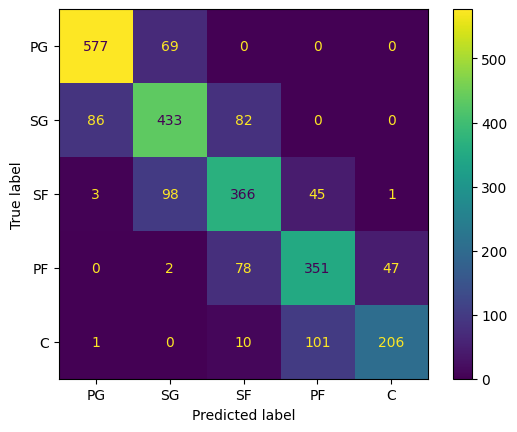

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay

y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

displ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=['PG', 'SG', 'SF', 'PF', 'C']),
                               display_labels=['PG', 'SG', 'SF', 'PF', 'C'])
displ.plot()


In [100]:
y = season_data['Pos']
y = le.fit_transform(y)
X = season_data[['height_inches', 'AST%', 'weight', 'TRB%', 'DRB%', 'ORB%', 'BLK%', '3PAr', 'TOV%', 'AST']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

KeyError: "['weight'] not in index"

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# criterion="entropy", max_depth=5
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy-")
print(str(accuracy * 100) + "%")

print("\nSummary Statistics-")
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

"""
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = list(X_train.columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('dtree-min.png')
Image(graph.create_png())
"""


Accuracy-
68.7793427230047%

Summary Statistics-


"\ndot_data = StringIO()\nexport_graphviz(clf, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True,\n                feature_names = list(X_train.columns))\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_png('dtree-min.png')\nImage(graph.create_png())\n"

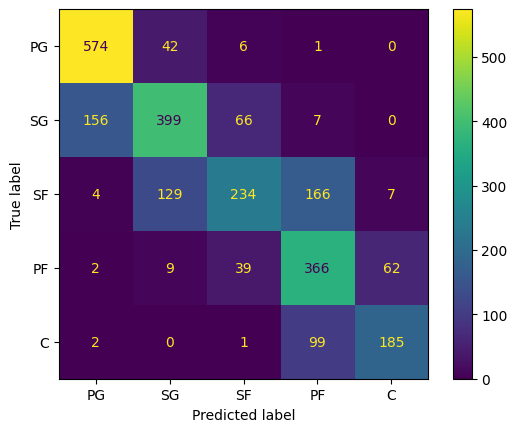

In [ ]:
y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

displ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=['PG', 'SG', 'SF', 'PF', 'C']),
                               display_labels=['PG', 'SG', 'SF', 'PF', 'C'])
displ.plot()